In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
import matplotlib.ticker as ticker
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn as nn
import timm
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import optim

/Users/mukulsherekar/opt/anaconda3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/mukulsherekar/opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <C0CD941A-7290-3098-8109-E3A1BBA30841> /Users/mukulsherekar/opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <FB753559-B5BA-3279-8C4E-2AB6619F0AE9> /Users/mukulsherekar/opt/anaconda3/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Question: 1 Loading the data and visualization

In [3]:
import cv2
IMGSIZE = [128,128]
CNAMES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
_labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
#_labels = [0,1,2,3,4,5]
# '/Users/mukulsherekar/Downloads/Intel_Image_Dataset/seg_train/seg_train'
_path = '/Users/mukulsherekar/Downloads/Intel_Image_Dataset'
path_1 =  '/seg_train/seg_train/'
print(_path + path_1)
print(_path + path_1 +  _labels[0])
path = _path + path_1 +  _labels[0]
X_tr, y_tr, X_ts, y_ts = [], [], [], []
for f in sorted([_ for _ in os.listdir(path) if _.lower().endswith('.jpg')]):
    X_tr += [cv2.resize(cv2.imread(os.path.join(path,f)), IMGSIZE)]
    y_tr += [CNAMES.index(_labels[0])]

/Users/mukulsherekar/Downloads/Intel_Image_Dataset/seg_train/seg_train/
/Users/mukulsherekar/Downloads/Intel_Image_Dataset/seg_train/seg_train/buildings


In [4]:
import torchvision
from torchvision import transforms


In [5]:
def seedEverthing(seed = 42):
    '''
    This function will seed everything.
    '''
    #NOTE: This function is not my original creation. 
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seedEverthing(seed = 42)

In [6]:
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [7]:
def get_distribution(path):
    '''
    This function shows some random images from all classes given a path of subdirectories.
    It also shows the distribution of images in every class
    '''
    classes = sorted(listdir_nohidden(path))
    d = {}
    plt.figure(figsize = (8,10), dpi = 80)
    f, axarr = plt.subplots(6,5)
    
    for i in range(len(classes)):
        
        #get some random images
        images = sorted(listdir_nohidden(path + classes[i] + '/'))
        rnd_imgs_plt = random.choices(images, k = 5)
        for img in range(len(rnd_imgs_plt)):
            
            x = np.array(Image.open(path + classes[i] + '/'+rnd_imgs_plt[img]))
            axarr[i, img].imshow(x)
            
            #set the y_axis name as class name only when its the leftmost image
            if img == 0:
                axarr[i, img].set_ylabel(classes[i])
            
            #set the X-axis and Y-axis tickers as False
            axarr[i, img].xaxis.set_major_locator(ticker.NullLocator())
            axarr[i, img].yaxis.set_major_locator(ticker.NullLocator())       
        
        #store the total number of images in a dictionary to plot distribution
        d[classes[i]] = len(images)
    #show the random images
    plt.show()
    
    #get a distribution and show the results in a barplot
    plt.bar(list(d.keys()), list(d.values()))
    plt.title('Distribution plots')
    plt.show()

<Figure size 640x800 with 0 Axes>

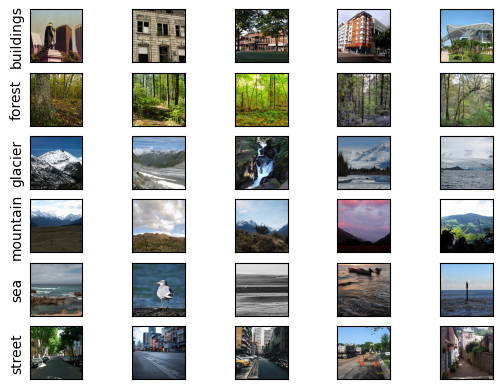

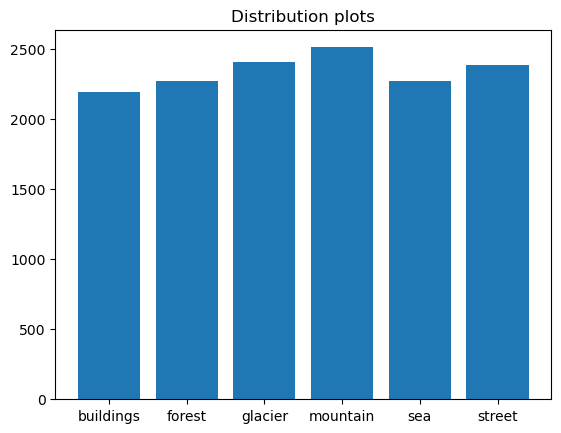

<Figure size 640x800 with 0 Axes>

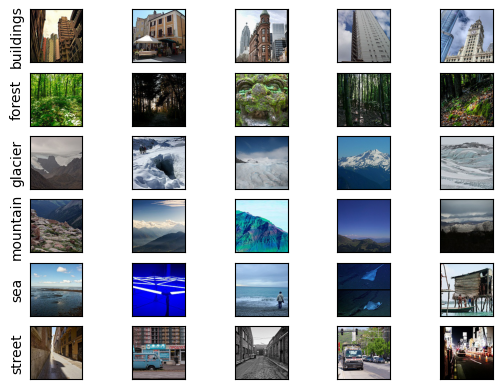

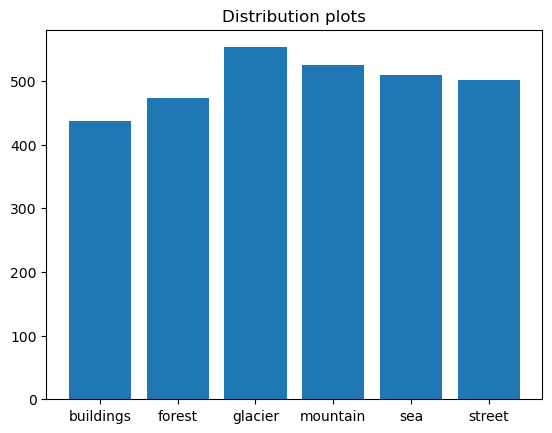

In [8]:
#preprocessing for training and testing
get_distribution('/Users/mukulsherekar/Downloads/Intel_Image_Dataset/seg_train/seg_train/')
get_distribution('/Users/mukulsherekar/Downloads/Intel_Image_Dataset/seg_test/seg_test/')



In [9]:
# Question: 2

In [10]:
class CreateDataset(Dataset):
    def __init__(self, path, train = False):
        super().__init__()
        '''
        This function will get a dataframe of image names and labels, define the transformations for images 
        and define the directory where all images are stored
        '''
        #create the dataframe with image names and labels so we don't load all images at once and overload the RAM
        final_images, final_labels = [], []
        classes = sorted(listdir_nohidden(path))
        for i in range(len(classes)):
                images = [classes[i] + '/' + x for x in sorted(listdir_nohidden(path + classes[i] + '/'))]
                labels = np.zeros((len(images), len(classes)))
                labels[:, i] = 1
                final_images = [*final_images, *images]
                final_labels = [*final_labels, *labels]

        self.df_train = pd.DataFrame(columns = classes, data = final_labels)
        self.df_train['Image'] = final_images
        self.df_train = self.df_train.sample(frac = 1)
        
        self.transforms = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float32), # change
            transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
        ])
        if train:
            self.transforms = transforms.Compose([
            transforms.Resize((128,128)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float32), # change
            transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
            ])
        self.directory = path
    
    def __len__(self):
        '''
        This function will return the total number of images
        '''
        return len(self.df_train)
    
    def __getitem__(self, idx):
        '''
        This function will open a particular image indexed by the input idx and return the image with its label
        '''
        img = Image.open(self.directory + self.df_train['Image'].iloc[idx])
        img = self.transforms(img)
        
        y = torch.Tensor(self.df_train[self.df_train.columns[self.df_train.columns!='Image']].iloc[idx].values)
        return img, y

In [11]:
class CreateDatasetTest(Dataset):
    def __init__(self, path):
        super().__init__()
        '''
        This function will get a dataframe of image names, define the transformations for images 
        and define the directory where all images are stored for the test set.
        There isnt much difference between CreateDatasetTest and Create Dataset except in this case, we dont have 
        labels
        '''
        #create the dataframe with image names so we don't load all images at once and overload the RAM
        final_images = sorted(listdir_nohidden(path))
        self.df_test = pd.DataFrame(data = np.array(final_images).reshape(-1,1),\
                                columns = ['Image'])
        
        self.transforms = transforms.Compose([
            transforms.Resize((128,128)),
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
            ])
        self.directory = path
    def __len__(self):
        '''
        This function will return the total number of images
        '''
        return len(self.df_test)
    
    def __getitem__(self, idx):
        '''
        This function will open a particular image indexed by the input idx and return the image
        '''
        img = Image.open(self.directory + self.df_test['Image'].iloc[idx])
        img = self.transforms(img)
        
        return img

    

In [12]:
batch_size = 64



In [13]:
#define Datasets and DataLoaders
train_data = CreateDataset('/Users/mukulsherekar/Downloads/Intel_Image_Dataset/seg_train/seg_train/', train = True)
val_data = CreateDataset('/Users/mukulsherekar/Downloads/Intel_Image_Dataset/seg_test/seg_test/')
test_data = CreateDatasetTest('/Users/mukulsherekar/Downloads/Intel_Image_Dataset/seg_pred/seg_pred/')
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_data, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)


In [14]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")



Using device: cpu


In [15]:
print(train_data[0][0].shape)
print(train_data[0][1].shape)

torch.Size([3, 128, 128])
torch.Size([6])


In [16]:
# Question: # Model preparation

In [17]:
def ReLU(x):
	return max(0.0, x)


In [18]:
# 1st attempt
hidden_units = [32,16]
image_size = train_data[0][0].shape # [3, 128, 128]
input_size = batch_size * image_size[0] * image_size[1] * image_size[2]
all_layers = [nn.Flatten()]
for hidden_unit in hidden_units:
    layer = nn.Linear(input_size, hidden_unit)
    all_layers.append(layer)
    all_layers.append(torch.nn.ReLU())
    input_size = hidden_unit
all_layers.append(nn.Linear(hidden_units[-1], 6)) # check if 10 instead of 6
model = nn.Sequential(*all_layers)
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3145728, out_features=32, bias=True)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=16, bias=True)
  (4): ReLU()
  (5): Linear(in_features=16, out_features=6, bias=True)
)

In [19]:
# 2nd attempt
Model = nn.Sequential()
Model.add_module('flatten', nn.Flatten())
Model.add_module('Layer:1', nn.Linear(49152, 32))
Model.add_module('relu', nn.ReLU())
Model.add_module('dropout', nn.Dropout(p=0.5))
Model.add_module('Layer:2', nn.Linear(32,16))
Model.add_module('Out', nn.Linear(16,6))
Model

Sequential(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (Layer:1): Linear(in_features=49152, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (Layer:2): Linear(in_features=32, out_features=16, bias=True)
  (Out): Linear(in_features=16, out_features=6, bias=True)
)

In [20]:
x = torch.ones((32,3,128,128))
Model(x).shape

torch.Size([32, 6])

In [21]:
# Model implementation

loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.MSELoss()
#optimizer = optim.SGD(net.parameters(), lr=0.01)
optimizer = torch.optim.Adam(Model.parameters(), lr =0.001)
torch.manual_seed(1)
num_epochs = 20 
for epoch in range(num_epochs):
    accuracy_hist_train = 0
    for x_batch, y_batch in train_loader:
        pred = Model(x_batch)
        print(pred.shape)
        loss = loss_fn(pred, y_batch) 
        print(loss.shape)
        loss.backward
        optimizer.step()
        optimizer.zero_grad()
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        print(is_correct)
        
        accuracy_hist_train /= len(train_loader.dataset)
        print(f'Epoch{epoch} Accuracy'
              f'{accuracy_hist_train: .4f}')

torch.Size([64, 6])
torch.Size([])


RuntimeError: The size of tensor a (64) must match the size of tensor b (6) at non-singleton dimension 1

In [ ]:
# Another attempt
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)    
            loss.backward
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] /= len(train_dl.dataset)
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        
        with torch.no_grad:
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)    
                loss.backward
                optimizer.step()
                optimizer.zero_grad()
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: '
              f'{accuracy_hist_train[epoch]: .4f} val_accuracy: '
              f'{accuracy_hist_valid[epoch]: .4f}')
        return loss_hist_train, loss_hist_valid, \
                accuracy_hist_train, accuracy_hist_valid
                
            

            
        
    

In [ ]:
torch.manual_seed(1)
num_epochs = 1
hist = train(Model, num_epochs, train_loader, val_loader)

In [ ]:
# Question 4 Improving the neural network model

In [ ]:
# A neural netowrk model can be imporved by increasing hidden layers
# changing activation function, changing activation function in
# output layer, Increasing number of neurons, weight initialization
# Normalizing/scaling the data